In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Read Files

In [3]:
# normalized data, with GA effect
#data = pd.read_csv("esetSC2_normalized.csv")

# data here is normalized, and the GA effect is removed.
data = pd.read_csv("esetSC2_remove_effect.csv")

# data information
data_info = pd.read_csv('anoSC2_v20_nokey.csv')

# GA information
GA_info = pd.read_csv("allSamplesSC1and2.csv")

GA_infomation = GA_info.set_index("SampleID")
GA_infomation = GA_infomation.loc[data.columns]
data_infomation = data_info.reset_index().set_index("SampleID").drop(columns = 'index')
data_infomation = data_infomation.loc[data.columns]
data_infomation = data_infomation[(data_infomation['Group']=='Control') | (data_infomation['Group']=='sPTD')]
data = data[data_infomation.index]
data_copy = data

## Split the data into train and test

In [4]:
def SampleList_To_Group(sample_list, data_infomation = data_infomation):
    control_sample = []
    sPTD_sample = []
    sample_group = []
    for sample in sample_list:
        group = data_infomation.loc[[sample]][['Group']].values[0][0]
        if group == 'Control':
            control_sample.append(sample)
            sample_group.append('Control')
        if group == 'sPTD':
            sPTD_sample.append(sample)
            sample_group.append('sPTD')
    return sample_group, control_sample, sPTD_sample

In [5]:
sample_list = list(data.columns)
sample_group, control_sample, sPTD_sample = SampleList_To_Group(sample_list)
xtrain,xtest,ytrain,ytest = train_test_split(data.transpose(), sample_group,test_size=0.2, random_state=1)
xtrain_copy = xtrain
ytrain_copy = ytrain

## Preliminary Feature Selection: Choose genes with high t-test score in different GA and all GAs

Select genes: local similarity >= 3 (in different GA) and global similarity >= 2 (in all GA)

In [6]:
control_sample = []
sPTD_sample = []
sapmles = list(xtrain.index)
sample_group, control_sample, sPTD_sample = SampleList_To_Group(sapmles)
sPTD_data = xtrain.transpose()[control_sample + sPTD_sample]
df = sPTD_data
df[['Control_mean', 'Control_std']] = df[control_sample].agg(['mean', 'std'], axis=1)
df[['sPTD_mean', 'sPTD_std']] = df[sPTD_sample].agg(['mean', 'std'], axis=1)
def welch_t_test(row):
    return (
        (row['Control_mean'] - row['sPTD_mean']) / 
        np.sqrt(row['Control_std']/len(control_sample) + row['sPTD_std']/len(sPTD_sample))
    )
df['similarity'] = df[['Control_mean', 'Control_std', 'sPTD_mean', 'sPTD_std']].apply(welch_t_test, axis=1)
df['similarity_abs'] = abs(df['similarity'])
df_sorted = df.sort_values('similarity_abs',ascending=False)

In [7]:
df_dict_GA=pickle.load(open('df_dict_GA_1.txt', 'rb'))
gene_similarity = []
for key in df_dict_GA:
    df = df_dict_GA[key]
    gene = df.loc[df["similarity_abs"] >= 3].index.tolist()
    gene_similarity = gene_similarity + gene
gene = sPTD_data.loc[df_sorted["similarity_abs"] >= 2].index.tolist()
gene_similarity = gene_similarity + gene
gene_similarity = np.unique(gene_similarity)
xtrain = xtrain[gene_similarity]
xtest = xtest[gene_similarity]
xtrain_copy = xtrain

## Resampling

In [8]:
import random
def resample(xtrain,ytrain,random_state=1):
    random.seed(random_state)
    sample_list = list(xtrain.index)
    sample_group, control_sample, sPTD_sample = SampleList_To_Group(sample_list)
    if len(control_sample) > len(sPTD_sample):
        Large_sample = control_sample
        Small_sample = sPTD_sample
    else:
        Large_sample = sPTD_sample
        Small_sample = control_sample
    samples = Small_sample+Large_sample
    for i in range(len(Large_sample)-len(Small_sample)):
        samples.append(random.sample(Small_sample,1)[0])
    sample_group, control_sample, sPTD_sample = SampleList_To_Group(samples)
    return samples,sample_group

In [9]:
# FROM SKLEARN DOCS: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

# THIS FUNCTION DOES NOT WORK WELL WITH ONLY 2 CLASSES

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(cm.shape)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(-0.5, cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Random Forest

Accuracy: 0.8823529411764706
Normalized confusion matrix
[[0.         1.        ]
 [0.04255319 0.95744681]]
(2, 2)


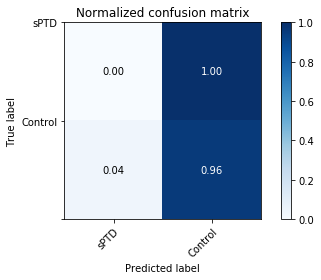

In [10]:
xtrain = xtrain_copy
ytrain = ytrain_copy
x_samples,ytrain = resample(xtrain,ytrain,random_state=1)
xtrain = xtrain.loc[x_samples]
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=1)
clf.fit(xtrain, ytrain)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]

pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
correct_num = 0
for i in range(len(y_test)):
    if y_test[i]==pred[i]:
        correct_num = correct_num+1
Accuracy = correct_num/len(y_test)
print('Accuracy:',Accuracy)
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

In [11]:
clf.predict(xtest)

array(['Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'sPTD', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'sPTD',
       'Control', 'Control', 'Control'], dtype='<U7')

## Support Vector Machine

Accuracy: 0.9019607843137255
Normalized confusion matrix
[[0.5        0.5       ]
 [0.06382979 0.93617021]]
(2, 2)


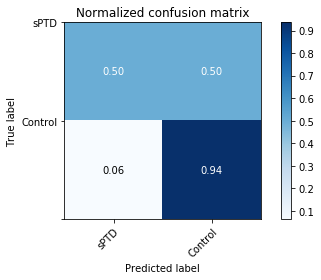

In [12]:
xtrain = xtrain_copy
ytrain = ytrain_copy
x_samples,ytrain = resample(xtrain,ytrain,random_state=1)
xtrain = xtrain.loc[x_samples]
clf = svm.SVC(gamma='scale')
clf.fit(xtrain, ytrain)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
correct_num = 0
for i in range(len(y_test)):
    if y_test[i]==pred[i]:
        correct_num = correct_num+1
Accuracy = correct_num/len(y_test)
print('Accuracy:',Accuracy)
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)